#  Population model with finite carrying capacity
*This Jupyter notebook presents the __Lotka-Volterra model__  between two species, supposing both species have finite carrying capacity.*
This notebook is based on the work of [Justin Bois](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/r6_sympy.html) and will adress the example and extercises of praragraf 6.4 of Strogatz's *Nonlinear Dynamics and Chaos*.

In [1]:
# Numerical package
import numpy as np

#Differential equation numerical solver
from scipy.integrate import odeint

# Import pyplot for plotting
import matplotlib.pyplot as plt

# To compute symbolic expressions
import sympy
# print outputs in LaTeX
sympy.init_printing(use_unicode=True) 

# Interactive manipulations in the notebook
#from ipywidgets import interact

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline.
%config InlineBackend.figure_formats = {'png', 'retina'}

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Lotka-Volterra equations

The coupled first-order non-linear differential Lotka-Volterra equations are given by:
\begin{align}
    \frac{dN_1}{dt} &= r_1 N_1 \left( \frac{K_1 - N_1 - \alpha N_2}{K_1} \right),\\[1em]
    \frac{dN_2}{dt} &= r_2 N_2 \left( \frac{K_2 - N_2 - \beta N_1}{K_2} \right),
\end{align}
where
- $N_i$ = population size of species $i$
- $t$ = time
- $r_i$ = species $i$ growth rate
- $K_i$ = environment carrying capacity (that reflect the competition within a species)
- $\alpha, \; \beta$ = inter-species interaction parameters.

If species 2 is the predator and species 1 is the prey, then $\alpha$ must be positive (since the predator eats the prey reducing its population) and $\beta$ must be negative since the predator needs the prey to get food.

In Strogatz's *Nonlinear Dynamics and Chaos*, the equations are presented as:
\begin{align}
    \dot{N_1} &= r_1 N_1 \left( 1 - \frac{N_1}{K_1} - b_1 N_2 \right),\\[1em]
    \dot{N_2} &= r_2 N_2 \left( 1 - \frac{N_2}{K_2} - b_2 N_1 \right),
\end{align}
where $b_1 = \frac{\alpha}{K_1}$ and $b_2 = \frac{\beta}{K_2}$ are competition parameters between species



## SymPy for Lotka-Volterra

To start working with `sympy` the first thing we have to do is to define the variables that we will use for our symbolic calculations.

In [2]:
# We split the definitions with the type of variables 
# r variables
r1, r2  = sympy.symbols('r_1 r_2', real=True)
# b variable
b1, b2 = sympy.symbols('b_1 b_2', real=True) #, positive=True
# K variable
K1, K2 = sympy.symbols('K_1 K_2', real=True, positive=True) # real=True


#function for species 1 and 2
N1, N2 = sympy.symbols('N_1 N_2', cls=sympy.Function) 

#temporal value
tau = sympy.symbols('tau')

We can now define the differential equations in sympy

In [3]:
diffeq1 = sympy.Eq(N1(tau).diff(tau),  r1 * N1(tau) *(1 - 1/K1*N1(tau) - b1*N2(tau)) )
diffeq2 = sympy.Eq(N2(tau).diff(tau),  r2 * N2(tau) *( 1- 1/K2*N2(tau) - b2*N1(tau)) )

And in the `IPython notebook` we can nicely display it as $\LaTeX$.

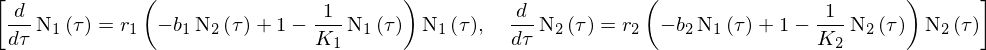

In [4]:
[diffeq1, diffeq2]

### Stationary states
Now we find the steady state, i.e. find when the derivative with respect to time equals to zero.

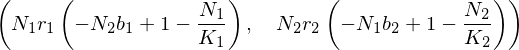

In [5]:
# set new time-independent variables
N1, N2 = sympy.symbols('N_1 N_2' ) #, real=True, positive=True
listSubsVarib=[(N1(tau),N1), (N2(tau),N2)]

diffeq1.rhs.subs(listSubsVarib),diffeq2.rhs.subs(listSubsVarib)

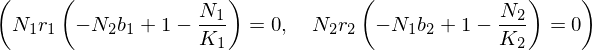

In [6]:
ss_N1 = sympy.Eq(diffeq1.rhs.subs(listSubsVarib), 0) #.simplify().expand()
ss_N2 = sympy.Eq(diffeq2.rhs.subs(listSubsVarib), 0)
ss_N1, ss_N2

In [7]:
print('Nullclines:')
sympy.solve(ss_N1,N1), sympy.solve((ss_N2),N2)

Nullclines:


And now we just tell `sympy` to solve for the species population!

So we find that there are 4 steady state solution: the trivial solution in which both species are extinct, so $N_1 = N_2 = 0$, two solutions, where only one population survives and finally a solution in which both species maintain their non-zero populations.

Sympy will show correctly the solutions when the $b$ parameters are supposed not only to be real but also positive.

The steady state solution for both species are:


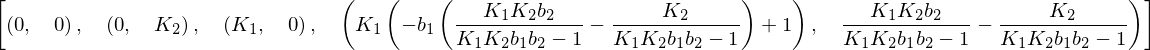

In [8]:
print('The steady state solution for both species are:')
ss_dict_N1N2 = sympy.solve((ss_N1, ss_N2), (N1, N2), manual=True) # manual=True particular=True, force=True
ss_dict_N1N2

### Jacobian

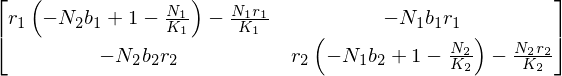

In [9]:
M=sympy.Matrix([ss_N1.lhs, ss_N2.lhs])
Jvar = sympy.Matrix([N1, N2])
J=M.jacobian(Jvar)
J

In [10]:
 #Here we create a numerical version of the Jacobian matrix
d2N_dt2_num = sympy.utilities.lambdify([N1,N2, r1,r2, b1,b2, K1,K2], J, ("math", "mpmath", "sympy"))

The Eigenvalues:


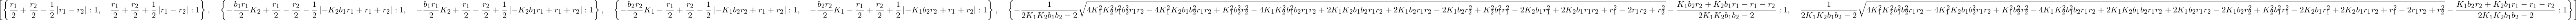

In [11]:
EigenVal = []
for ssSol in ss_dict_N1N2:
    replacements = []
    replacements = [(N, ssSol[i]) for i, N in enumerate([N1, N2])]
    EigenVal.append(J.subs(replacements).eigenvals()) #eigenvals  eigenvects
print('The Eigenvalues:')
EigenVal

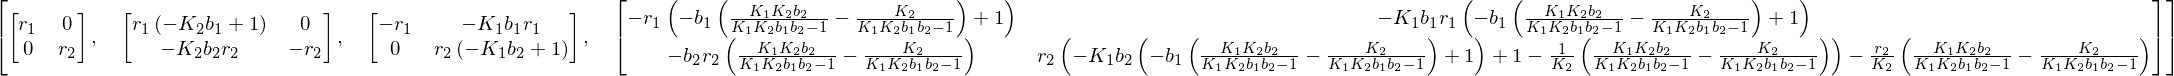

In [12]:
StStateMatrix = []
for ssSol in ss_dict_N1N2:
    replacements = []
    replacements = [(N, ssSol[i]) for i, N in enumerate([N1, N2])]
    StStateMatrix.append(J.subs(replacements))
StStateMatrix

## Numerical simulation

We are going to lambdify the following equations:


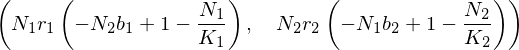

In [13]:
print('We are going to lambdify the following equations:')
ss_N1.lhs, ss_N2.lhs

In [14]:
# Generate 'lambdify' functions to numerically evaluate the diff. equations
dN_dt_num = sympy.utilities.lambdify([N1,N2, r1,r2, b1,b2, K1,K2], [ss_N1.lhs, ss_N2.lhs], ("math", "mpmath", "sympy"))

In [15]:
def lotka_voltera_rhs(n1_n2, t, *p):
    '''
    Set up the right hand side (rhs) function for the system 
    (necessary step to feed sympy's odeint function).
    '''
    # unpack the variables
    n1, n2 = n1_n2
    
    # unpack the parameters
    r1,b1,K1, r2,b2,K2 = p
    
    evald_dt=dN_dt_num(n1, n2, r1, r2, b1, b2, K1, K2)
    
    return np.array([evald_dt[0], 
                    evald_dt[1]])

### Example 1

Now let's define the parameters and numerically solve the system of equations in [Justin Bois](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/r6_sympy.html) 

In [16]:
# let's set the parameter values by species
r_1, r_2 = [0.5, 0.2]
k1, k2 = [100, 50]
a, b = [1.2, 0.2]

argsPar = (r_1,a/k1,k1, r_2,b/k2,k2)

# Initial population size
n1_n2_0 = [2, 2] #np.array([2, 2])

# Time points we want to consider
t = np.linspace(0, 100, 1000)

argsPar
# Now let's use odeint to solve the function
sol_n1n2, infodict = odeint(lotka_voltera_rhs, n1_n2_0, t, args=argsPar, full_output = True )
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

We will now plot the solution.

But let's include the steady state solutions we previously found to see if indeed the populations are converging over time to this steady state.
For this we will simply use the `subs` function to replace the values that we chose for the parameters.

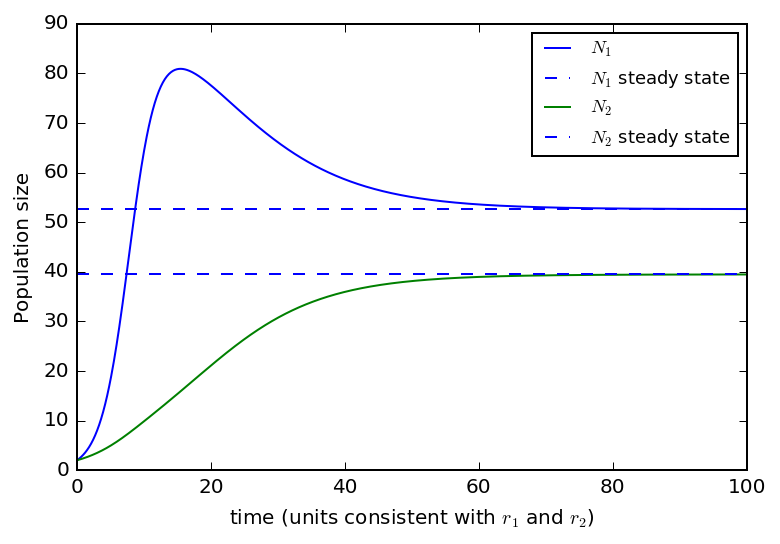

In [17]:
for i, N in enumerate([N1, N2]):
    plt.plot(t, sol_n1n2[:, i], label=r'${0:s}$'.format(sympy.latex(N)))
    plt.axhline(y=ss_dict_N1N2[3][i].subs({K1: k1, K2: k2, b1: (a/k1), b2: (b/k2)}),
                linestyle='--',
                label=r'${0:s}$ steady state'.format(sympy.latex(N)))

plt.legend(loc=0, fontsize=9)
plt.xlabel('time (units consistent with $r_1$ and $r_2$)')
plt.ylabel('Population size');

### Example 2

In this example we solve on the *Lotka-Volterra competition model*, presented in S.Strogatz - Nonlinear Dynamics and Chaos.

We suppose that both species are competing for the same food supply (grass). The equations are:
\begin{align}
    \dot{x} &= x(3-x-2y),\\[1em]
    \dot{y} &= y(2-x-y),
\end{align}

where
- $x(t)$ = population of rabbits,
- $y(t)$ = population of sheep

(see Strogatz - *Nonlinear Dynamics and Chaos*)


In [18]:
# let's set the parameter values by species
r_1, b_1, k1 = [3, 2/3, 1/(1/3)]
r_2, b_2, k2 = [2, 1/2, 1/(1/2)]
argsPar = (r_1,b_1,k1, r_2,b_2,k2)

# Initial population size
n1_n2_0 = np.array([10, 5])

# Time points we want to consider
t = np.linspace(0, 15, 1000)

argsPar
# Now let's use odeint to solve the function
sol_n1n2, infodict = odeint(lotka_voltera_rhs, n1_n2_0, t, args=argsPar, full_output = True )
infodict['message'] 

'Integration successful.'

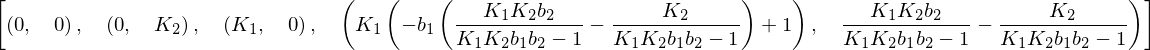

In [19]:
ReplParamVal=({K1: k1, K2: k2, b1: b_1, b2: b_2 ,r1:r_1 , r2:r_2 })
ss_dict_N1N2

In [20]:
EqPoint=[[elem[0].subs(ReplParamVal),elem[1].subs(ReplParamVal)] for elem in ss_dict_N1N2]
EqPoint

We now consider the four fixed point.

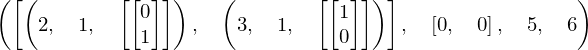

In [21]:
Eigen=[]
Trace=[]
Deter=[]
for Matrix in StStateMatrix:
    Eigen.append(Matrix.subs(ReplParamVal).eigenvects())
    Trace.append(Matrix.subs(ReplParamVal).trace())
    Deter.append(Matrix.subs(ReplParamVal).det())

Eigen[0], EqPoint[0], Trace[0], Deter[0]

Point $(0,0)$ has eigenvalues $\lambda=2,3$, i.e. positive trace and determinant: is an *unstable node*.

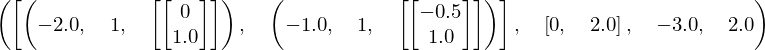

In [22]:
Eigen[1], EqPoint[1], Trace[1], Deter[1]

Point $(0,K_1)$ has eigenvalues $\lambda=-2,-1$, i.e. negative trace and positive determinant: is a *stable node*.

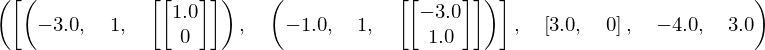

In [23]:
Eigen[2], EqPoint[2], Trace[2], Deter[2]

Point $(K_2,0)$ has eigenvalues $\lambda=-3,-1$, i.e. negative trace and positive determinant: is a *stable node*.

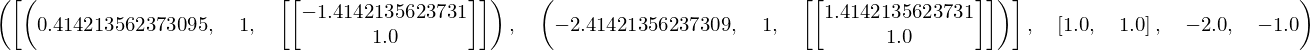

In [24]:
Eigen[3], EqPoint[3], Trace[3], Deter[3]

Point $(1,1)$ has eigenvalues $\lambda=-1\pm \sqrt{2}$, i.e. negative trace and determinant: it is a *saddle node*.

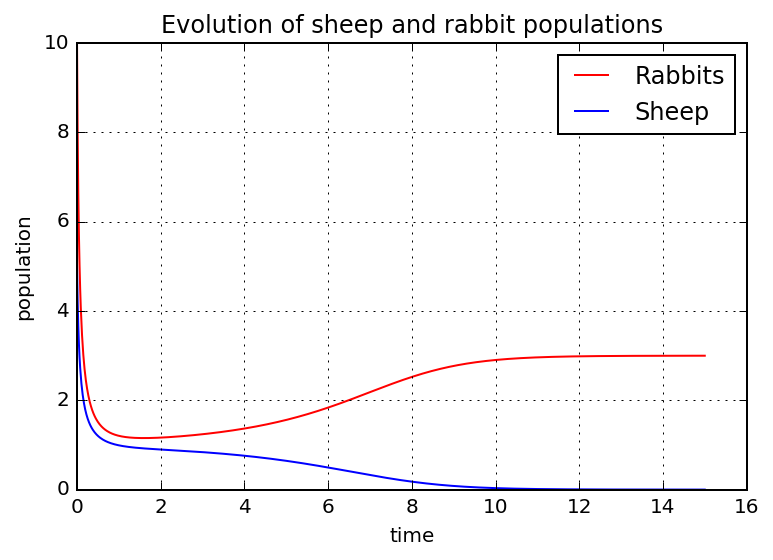

In [25]:
f1 = plt.figure()
plt.plot(t, sol_n1n2[:, 0], 'r-', label='Rabbits')
plt.plot(t, sol_n1n2[:, 1]  , 'b-', label='Sheep')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of sheep and rabbit populations')
plt.show()
f1.savefig('OutImage/LV_rabbits_and_sheep_1.png')

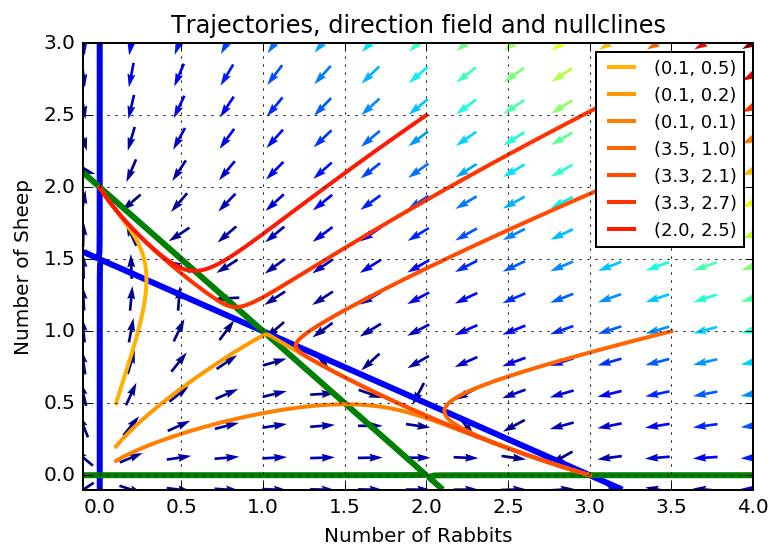

In [26]:
#X_f1= np.array(EqPoint[1][:], dtype=np.float64)
#X_fs= np.array(n1_n2_0 , dtype=np.float64) #n1_n2_0 EqPoint[1][:]
#StartPoints = np.array([X_fs, [X_f1[0]+2,X_f1[1]+7],[15,5], [X_f1[0]+7,X_f1[1]+1], [40,70], [20,40], X_f1])  # position of X0 between X_f0 and X_f1

StartPoints = np.array([[0.1,0.5], [0.1,0.2], [0.1,0.1],[3.5,1], [3.3,2.1], [3.3,2.7] , [2,2.5] ])  # position of X0 between X_f0 and X_f1
values  = np.linspace(0.3, 0.9, len(StartPoints)) 
t = np.linspace(0, 15, 1000)

f2 = plt.figure()
# plot trajectories
for point, v in zip(StartPoints, values): 
    X0 = point                     # starting point (internal)
    sol_n1n2 = odeint(lotka_voltera_rhs, np.transpose(X0), t, args=argsPar, rtol=10.**-12, atol=10.**-12)
    plt.plot( sol_n1n2[:,0], sol_n1n2[:,1], lw=2, color=plt.cm.autumn_r(v), label='(%.1f, %.1f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = 3                   # get axis limits
xmax = 4 
ymin = -.1
xmin = -.1

nb_points   = 15                      
xGrid = np.linspace(xmin, xmax, nb_points)
yGrid = np.linspace(ymin, ymax, nb_points)
X1 , Y1  = np.meshgrid(xGrid, yGrid)                       # create a grid
DX1, DY1 = dN_dt_num(X1, Y1,r_1, r_2, b_1, b_2, k1, k2)    # compute growth rate on the gridt
M = (np.hypot(DX1, DY1))                                   # Norm of the growth rate 
M[ M == 0] = 1.                                            # Avoid zero division errors 
DX1 /= M                                                   # Normalize each arrows
DY1 /= M                                  
#-------------------------------------------------------
# Draw direction fields, using matplotlib 's quiver function
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)



# Now find the nullclines.  Use matplotlib's contour routine to find the zero level.
# We will need a fine mesh, reevaluate DX1 and DY1 on the finer grid, and use contour 
# to find the level curves
xGrid = np.linspace(xmin, xmax, nb_points*10)
yGrid = np.linspace(ymin, ymax, nb_points*10)
X1 , Y1  = np.meshgrid(xGrid, yGrid)                    
dX1, dY1 = dN_dt_num(X1, Y1,r_1, r_2, b_1, b_2, k1, k2)
plt.contour(X1, Y1, dX1, levels=[0], linewidths=3, colors='blue')
plt.contour(X1, Y1, dY1, levels=[0], linewidths=3, colors='green')


plt.title('Trajectories, direction field and nullclines')
plt.xlabel('Number of Rabbits')
plt.ylabel('Number of Sheep')
plt.legend(loc='best', fontsize=9)
plt.grid()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()
f2.savefig('OutImage/LV_rabbits_and_sheep_2.png')
